In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.sparse.csgraph import connected_components, shortest_path
from pprint import pprint
from time import time

%matplotlib inline

# I know both of the below won't work haha
# TODO: test non square dungeons
# TODO: test square densities other than 3

In [237]:
class Dungeon:
    def __init__(self, party, m=10, n=10, p_wall=0.3, square_density=3, plot_size=10):
        self.party = party
        self.avg_party_level = self._avg_party_level(party)
        
        self.m = m
        self.n = n
        self.square_density = square_density
        self.p_wall = p_wall
        self.plot_size = plot_size
        self.difficulty_dict = {
            'Trivial': 0,
            'Easy': 1,
            'Medium': 2,
            'Hard': 3,
            'Deadly': 4,
            0: 'Trivial',
            1: 'Easy',
            2: 'Medium',
            3: 'Hard',
            4: 'Deadly'
        }
        self.latest_direction = 's'
        self.lost = False
        
        self.generate_map()
        self.place_encounters()
        
        self.player_exp_df = pd.read_csv('dnd_player_exp', index_col=0)
        self.monster_df = pd.read_csv('dnd_monsters.csv', index_col=0)
        self.monster_df['cr'] = self.monster_df.apply(self._extract_cr, axis=1)
        
        self.generate_all_encounters()


    # methods
    def check_for_encounter(self):
        if 'Deadly' not in self.encounter_locs:
            return
        
        short_paths = shortest_path(self.C)
        closest_encounter = 'Deadly'
        closest_dist = short_paths[
            self._get_ind(*self._dense_to_granular(*self.party_location)), 
            self._get_ind(*self._dense_to_granular(*self.encounter_locs['Deadly']))
        ]
        for diff in self.encounter_locs:
            new_dist = short_paths[
                self._get_ind(*self._dense_to_granular(*self.party_location)), 
                self._get_ind(*self._dense_to_granular(*self.encounter_locs[diff]))
            ]
            if new_dist < closest_dist:
                closest_encounter = diff
                closest_dist = new_dist
        
        if closest_dist <= 2:
            party_i, party_j = self._dense_to_granular(*self.party_location)
            encounter_i, encounter_j = self._dense_to_granular(*self.encounter_locs[closest_encounter])
            
            # number of paths to get from party to encounter in 2 steps
            num_paths = (self.C@self.C)[
                self._get_ind(party_i, party_j), 
                self._get_ind(encounter_i, encounter_j)
            ]
            
            if (party_i == encounter_i) or (party_j == encounter_j):
                self.run_encounter(closest_encounter)
            
            elif num_paths > 1:
                self.run_encounter(closest_encounter)
            
            elif num_paths == 1:
                print(closest_encounter, ":")
                print(self.encounters[closest_encounter])
    
    def generate_map(self):
        """
        Given dimensions m and n, generate a dungeon map.

        Parameters
        ----------
        m, n:  int
            Integers representing the dimensions of the dungeon.

        p_wall:  float, optional
            Float between 0 and 1, specifies the density of
            walls within the dungeon.
        

        Returns
        -------
        A:  numpy array
            Array representing the vertical walls within the 
            dungeon. If A[i, j] is 1, there is a wall at i, j.
            A is m x n-1.

        B:  numpy array
            Array representing the horizontal walls within the 
            dungeon. If B[i, j] is 1, there is a wall at i, j.
            B is m-1 x n.

        C:  numpy array
            Undirected adjacency matrix for the dungeon. C[i, j]
            is 1 if the jth square is adjacent to the ith square.
            Used to determine connected components.
            C is m*n x m*n.

        """
        m = self.m
        n = self.n
        p_wall = self.p_wall
        
        def _adjacency(A, B):
            """
            Helper function to determine the adjacency matrix
            C from wall matrices A and B.
            """
            m, n = A.shape[0], B.shape[1]
            C = np.zeros((m*n, m*n))  # C is m*n x m*n

            def _get_i_j(ind):
                """
                Helper function to get the i, j index of a 
                square within the grid given its index in C.
                """
                i = ind // n
                j = ind % n
                return i, j

            def _get_ind(i, j):
                """
                Helper function to get the index in C given
                a square's i, j index within the grid.
                """
                return i*n + j

            # loop over all squares in the grid
            for ind in range(m*n):
                i, j = _get_i_j(ind)

                if i != 0:  # look up
                    if B[i-1, j] == 0:  # check for walls
                        C[ind, _get_ind(i-1, j)] = 1

                if i != m-1:  # look down
                    if B[i, j] == 0:  # check for walls
                        C[ind, _get_ind(i+1, j)] = 1

                if j != 0:  # look left
                    if A[i, j-1] == 0:  # check for walls
                        C[ind, _get_ind(i, j-1)] = 1

                if j != n-1:  # look right
                    if A[i, j] == 0:  # check for walls
                        C[ind, _get_ind(i, j+1)] = 1

            return C + np.eye(m*n)

        # get random wall matrices using p_wall
        A = np.random.choice(2, size=(m, n-1), p=[1-p_wall, p_wall])
        B = np.random.choice(2, size=(m-1, n), p=[1-p_wall, p_wall])
        C = _adjacency(A, B)

        # loop until connected components condition is satisfied
        # TODO: add either a maxiter or a timeout
        while connected_components(C)[0] > 1:
            A = np.random.choice(2, size=(m, n-1), p=[1-p_wall, p_wall])
            B = np.random.choice(2, size=(m-1, n), p=[1-p_wall, p_wall])
            C = _adjacency(A, B)
        
        self.A = A  # vertical walls
        self.B = B  # horizontal walls
        self.C = C  # adjacency matrix
    
    def generate_all_encounters(self):
        self.encounters = {
            'Deadly': self.generate_encounter('Deadly'),
            'Hard': self.generate_encounter('Hard'),
            'Medium': self.generate_encounter('Medium'),
            'Easy': self.generate_encounter('Easy')
        }
    
    def generate_encounter(self, difficulty):
        party = self.party

        difficulty = self.difficulty_dict[difficulty]

        def _cr_threshold(row):
            cr = row['cr']
            if pd.isna(cr):
                return False
            elif cr <= self.avg_party_level:
                return True
            else:
                return False

        def _max_monsters(monsters, monster):
            while self._encounter_difficulty(monsters) < difficulty:
                monsters[monster] += 1

            if self._encounter_difficulty(monsters) > difficulty:
                monsters[monster] -= 1

            return monsters[monster]

        def _get_available_monsters(monsters, prev_available):
            available_monsters = []
            for monster in prev_available:
                if monster in monsters:
                    pass
                cp = monsters.copy()
                cp[monster] = 1
                if self._encounter_difficulty(cp) <= difficulty:
                    available_monsters.append(monster)
            return available_monsters

        monsters = dict()

        available_monsters = list(self.monster_df.index[
            self.monster_df.apply(_cr_threshold, axis=1)
        ])

        while self._encounter_difficulty(monsters) < difficulty:
            available_monsters = _get_available_monsters(monsters, available_monsters)
            if len(available_monsters) == 0:
                return self.generate_encounter(difficulty)
            
            p = self.monster_df[self.monster_df.index.isin(available_monsters)]['cr']
                
            monster = np.random.choice(
                available_monsters, 
                p=p/p.sum()
            )
            monsters[monster] = 1

            max_monster_quantity = _max_monsters(monsters, monster)
            monsters[monster] = np.random.randint(1, max_monster_quantity + 1)

        return monsters
    
    def generate_treasure(self):
        cr = self._avg_party_level(self.party)
        def _coins(cr):
            coins = dict()

            # using cr + 4 (for ex.) scales treasure more continuously
            # 3 values are the expected values of min_cr, avg_cr, max_cr
            if cr <= 4:
                coins['CP'] = 100 * self._roll(6, dx=cr + 4)  # 1800, 2250, 2700
                coins['SP'] = 100 * self._roll(3, dx=cr + 4)  # 900, 1125, 1350
                coins['GP'] = 10 * self._roll(2, dx=cr + 4)  # 60, 75, 90
            elif cr <= 10:
                coins['CP'] = 100 * self._roll(2, dx=cr - 1)  # 500, 750, 1000
                coins['SP'] = 1000 * self._roll(2, dx=cr - 1)  # 5000, 7500, 10000
                coins['GP'] = 100 * self._roll(6, dx=cr - 1)  # 1500, 2250, 3000
                coins['PP'] = 10 * self._roll(3, dx=cr - 1)  # 75, 112.5, 150
            elif cr <= 16:
                coins['GP'] = 1000 * self._roll(4, dx=cr - 7)  # 10000, 15000, 20000
                coins['PP'] = 100 * self._roll(5, dx=cr - 7)  # 1250, 1875, 2500
            else:
                coins['GP'] = 1000 * self._roll(12, dx=6)  # 42000
                coins['PP'] = 1000 * self._roll(8, dx=6)  # 28000

            return coins

        def _gems_art_magic(cr):
            roll = self._roll(1, dx=100)
            gem_art_magic = dict()
            if cr <= 4:
                if roll <= 6:
                    pass
                elif roll <= 16:
                    gem_art_magic['gems'] = {
                        10: self._roll(2, dx=6)  # value, quantity
                    }
                elif roll <= 26:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)
                    }
                elif roll <= 36:
                    gem_art_magic['gems'] = {
                        50: self._roll(2, dx=6)
                    }
                elif roll <= 44:
                    gem_art_magic['gems'] = {
                        10: self._roll(2, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'A': self._roll(1, dx=6)
                    }
                elif roll <= 52:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'A': self._roll(1, dx=6)
                    }
                elif roll <= 60:
                    gem_art_magic['gems'] = {
                        50: self._roll(2, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'A': self._roll(1, dx=6)
                    }
                elif roll <= 65:
                    gem_art_magic['gems'] = {
                        10: self._roll(2, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'B': self._roll(1, dx=4)
                    }
                elif roll <= 70:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'B': self._roll(1, dx=4)
                    }
                elif roll <= 75:
                    gem_art_magic['gems'] = {
                        50: self._roll(2, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'B': self._roll(1, dx=4)
                    }
                elif roll <= 78:
                    gem_art_magic['gems'] = {
                        10: self._roll(2, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=4)
                    }
                elif roll <= 80:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=4)
                    }
                elif roll <= 85:
                    gem_art_magic['gems'] = {
                        50: self._roll(2, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=4)
                    }
                elif roll <= 92:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'F': self._roll(1, dx=4)
                    }
                elif roll <= 97:
                    gem_art_magic['gems'] = {
                        50: self._roll(2, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'F': self._roll(1, dx=4)
                    }
                elif roll <= 99:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'G': 1
                    }
                else:
                    gem_art_magic['gems'] = {
                        50: self._roll(2, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'G': 1
                    }
            elif cr <= 10:
                if roll <= 4:
                    pass
                elif roll <= 10:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)  # value, quantity
                    }
                elif roll <= 16:
                    gem_art_magic['gems'] = {
                        50: self._roll(3, dx=6)
                    }
                elif roll <= 22:
                    gem_art_magic['gems'] = {
                        100: self._roll(3, dx=6)
                    }
                elif roll <= 28:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)
                    }            
                elif roll <= 32:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'A': self._roll(1, dx=6)
                    }
                elif roll <= 36:
                    gem_art_magic['gems'] = {
                        50: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'A': self._roll(1, dx=6)
                    }
                elif roll <= 40:
                    gem_art_magic['gems'] = {
                        100: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'A': self._roll(1, dx=6)
                    }
                elif roll <= 44:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'A': self._roll(1, dx=6)
                    }
                elif roll <= 49:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'B': self._roll(1, dx=4)
                    }
                elif roll <= 54:
                    gem_art_magic['gems'] = {
                        50: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'B': self._roll(1, dx=4)
                    }
                elif roll <= 59:
                    gem_art_magic['gems'] = {
                        100: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'B': self._roll(1, dx=4)
                    }
                elif roll <= 63:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'B': self._roll(1, dx=4)
                    }
                elif roll <= 66:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=4)
                    }
                elif roll <= 69:
                    gem_art_magic['gems'] = {
                        50: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=4)
                    }
                elif roll <= 72:
                    gem_art_magic['gems'] = {
                        100: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=4)
                    }
                elif roll <= 74:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=4)
                    }
                elif roll <= 76:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'D': 1
                    }
                elif roll <= 78:
                    gem_art_magic['gems'] = {
                        50: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'D': 1
                    }
                elif roll <= 79:
                    gem_art_magic['gems'] = {
                        100: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'D': 1
                    }
                elif roll <= 80:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'D': 1
                    }
                elif roll <= 84:
                    gem_art_magic['art'] = {
                        25: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'F': self._roll(1, dx=4)
                    }
                elif roll <= 88:
                    gem_art_magic['gems'] = {
                        50: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'F': self._roll(1, dx=4)
                    }
                elif roll <= 91:
                    gem_art_magic['gems'] = {
                        100: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'F': self._roll(1, dx=4)
                    }
                elif roll <= 94:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'F': self._roll(1, dx=4)
                    }
                elif roll <= 96:
                    gem_art_magic['gems'] = {
                        100: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'G': self._roll(1, dx=4)
                    }
                elif roll <= 98:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'G': self._roll(1, dx=6)
                    }
                elif roll <= 99:
                    gem_art_magic['gems'] = {
                        100: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'H': 1
                    }
                else:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'H': 1
                    }
            elif cr <= 16:
                if roll <= 3:
                    pass
                elif roll <= 6:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                elif roll <= 9:
                    gem_art_magic['art'] = {
                        750: self._roll(2, dx=4)
                    }
                elif roll <= 12:
                    gem_art_magic['gems'] = {
                        500: self._roll(3, dx=6)
                    }
                elif roll <= 15:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                elif roll <= 19:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'A': self._roll(1, dx=4),
                        'B': self._roll(1, dx=6)
                    }
                elif roll <= 23:
                    gem_art_magic['art'] = {
                        750: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'A': self._roll(1, dx=4),
                        'B': self._roll(1, dx=6)
                    }
                elif roll <= 26:
                    gem_art_magic['gems'] = {
                        500: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'A': self._roll(1, dx=4),
                        'B': self._roll(1, dx=6)
                    }
                elif roll <= 29:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'A': self._roll(1, dx=4),
                        'B': self._roll(1, dx=6)
                    }
                elif roll <= 35:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=6)
                    }
                elif roll <= 40:
                    gem_art_magic['art'] = {
                        750: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=6)
                    }
                elif roll <= 45:
                    gem_art_magic['gems'] = {
                        500: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=6)
                    }
                elif roll <= 50:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=6)
                    }
                elif roll <= 54:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'D': self._roll(1, dx=4)
                    }
                elif roll <= 58:
                    gem_art_magic['art'] = {
                        750: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'D': self._roll(1, dx=4)
                    }
                elif roll <= 62:
                    gem_art_magic['gems'] = {
                        500: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'D': self._roll(1, dx=4)
                    }
                elif roll <= 66:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'D': self._roll(1, dx=4)
                    }
                elif roll <= 68:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'E': 1
                    }
                elif roll <= 70:
                    gem_art_magic['art'] = {
                        750: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'E': 1
                    }
                elif roll <= 72:
                    gem_art_magic['gems'] = {
                        500: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'E': 1
                    }
                elif roll <= 74:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'E': 1
                    }
                elif roll <= 76:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'F': 1,
                        'G': self._roll(1, dx=4)
                    }
                elif roll <= 78:
                    gem_art_magic['art'] = {
                        750: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'F': 1,
                        'G': self._roll(1, dx=4)
                    }
                elif roll <= 80:
                    gem_art_magic['gems'] = {
                        500: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'F': 1,
                        'G': self._roll(1, dx=4)
                    }
                elif roll <= 82:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'F': 1,
                        'G': self._roll(1, dx=4)
                    }
                elif roll <= 85:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'H': self._roll(1, dx=4)
                    }
                elif roll <= 88:
                    gem_art_magic['art'] = {
                        750: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'H': self._roll(1, dx=4)
                    }
                elif roll <= 90:
                    gem_art_magic['gems'] = {
                        500: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'H': self._roll(1, dx=4)
                    }
                elif roll <= 92:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'H': self._roll(1, dx=4)
                    }
                elif roll <= 94:
                    gem_art_magic['art'] = {
                        250: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'I': 1
                    }
                elif roll <= 96:
                    gem_art_magic['art'] = {
                        750: self._roll(2, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'I': 1
                    }
                elif roll <= 98:
                    gem_art_magic['gems'] = {
                        500: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'I': 1
                    }
                else:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'I': 1
                    }
            else:
                if roll <= 2:
                    pass
                elif roll <= 5:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=8)
                    }
                elif roll <= 8:
                    gem_art_magic['art'] = {
                        2500: self._roll(1, dx=10)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=8)
                    }
                elif roll <= 11:
                    gem_art_magic['art'] = {
                        7500: self._roll(1, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=8)
                    }
                elif roll <= 14:
                    gem_art_magic['gems'] = {
                        5000: self._roll(1, dx=8)
                    }
                    gem_art_magic['magic items'] = {
                        'C': self._roll(1, dx=8)
                    }
                elif roll <= 22:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'D': self._roll(1, dx=6)
                    }
                elif roll <= 30:
                    gem_art_magic['art'] = {
                        2500: self._roll(1, dx=10)
                    }
                    gem_art_magic['magic items'] = {
                        'D': self._roll(1, dx=6)
                    }
                elif roll <= 38:
                    gem_art_magic['art'] = {
                        7500: self._roll(1, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'D': self._roll(1, dx=6)
                    }
                elif roll <= 46:
                    gem_art_magic['gems'] = {
                        5000: self._roll(1, dx=8)
                    }
                    gem_art_magic['magic items'] = {
                        'D': self._roll(1, dx=6)
                    }
                elif roll <= 52:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'E': self._roll(1, dx=6)
                    }
                elif roll <= 58:
                    gem_art_magic['art'] = {
                        2500: self._roll(1, dx=10)
                    }
                    gem_art_magic['magic items'] = {
                        'E': self._roll(1, dx=6)
                    }
                elif roll <= 63:
                    gem_art_magic['art'] = {
                        7500: self._roll(1, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'E': self._roll(1, dx=6)
                    }
                elif roll <= 68:
                    gem_art_magic['gems'] = {
                        5000: self._roll(1, dx=8)
                    }
                    gem_art_magic['magic items'] = {
                        'E': self._roll(1, dx=6)
                    }
                elif roll <= 69:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'G': self._roll(1, dx=4)
                    }
                elif roll <= 70:
                    gem_art_magic['art'] = {
                        2500: self._roll(1, dx=10)
                    }
                    gem_art_magic['magic items'] = {
                        'G': self._roll(1, dx=4)
                    }
                elif roll <= 71:
                    gem_art_magic['art'] = {
                        7500: self._roll(1, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'G': self._roll(1, dx=4)
                    }
                elif roll <= 72:
                    gem_art_magic['gems'] = {
                        5000: self._roll(1, dx=8)
                    }
                    gem_art_magic['magic items'] = {
                        'G': self._roll(1, dx=4)
                    }
                elif roll <= 74:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'H': self._roll(1, dx=4)
                    }
                elif roll <= 76:
                    gem_art_magic['art'] = {
                        2500: self._roll(1, dx=10)
                    }
                    gem_art_magic['magic items'] = {
                        'H': self._roll(1, dx=4)
                    }
                elif roll <= 78:
                    gem_art_magic['art'] = {
                        7500: self._roll(1, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'H': self._roll(1, dx=4)
                    }
                elif roll <= 80:
                    gem_art_magic['gems'] = {
                        5000: self._roll(1, dx=8)
                    }
                    gem_art_magic['magic items'] = {
                        'H': self._roll(1, dx=4)
                    }
                elif roll <= 85:
                    gem_art_magic['gems'] = {
                        1000: self._roll(3, dx=6)
                    }
                    gem_art_magic['magic items'] = {
                        'I': self._roll(1, dx=4)
                    }
                elif roll <= 90:
                    gem_art_magic['art'] = {
                        2500: self._roll(1, dx=10)
                    }
                    gem_art_magic['magic items'] = {
                        'I': self._roll(1, dx=4)
                    }
                elif roll <= 95:
                    gem_art_magic['art'] = {
                        7500: self._roll(1, dx=4)
                    }
                    gem_art_magic['magic items'] = {
                        'I': self._roll(1, dx=4)
                    }
                else:
                    gem_art_magic['gems'] = {
                        5000: self._roll(1, dx=8)
                    }
                    gem_art_magic['magic items'] = {
                        'I': self._roll(1, dx=4)
                    }

            return gem_art_magic

        treasure = _gems_art_magic(cr)
        treasure['coins'] = _coins(cr)

        if 'gems' in treasure:
            treasure['gems'] = self._gems_from_dict(treasure['gems'])

        if 'art' in treasure:
            treasure['art'] = self._art_from_dict(treasure['art'])

        if 'magic items' in treasure:
            treasure['magic items'] = self._magic_items_from_dict(treasure['magic items'])

        return treasure
    
    def obscure_plot(self, n_steps=2):
        self.obscured_squares = []
        party_location = self._dense_to_granular(*self.party_location)

        for ind in range(self.m*self.n):
            i, j = self._get_i_j(ind)
            if self._is_visible(party_location, (i, j), n_steps=n_steps):
                pass
            else:
                self.obscured_squares.append((i, j))
                self._obscure_square(i, j)
    
    def place_encounters(self):
        m = self.m
        n = self.n
        square_density = self.square_density
        
        D = np.zeros((square_density*m, square_density*n))

        short_paths = shortest_path(self.C)
        longest_path = np.unravel_index(short_paths.argmax(), self.C.shape)
        party_location_granular = self._get_i_j(longest_path[0], n)
        treasure_location_granular = self._get_i_j(longest_path[1], n)
        
        party_location = self._granular_to_dense(*party_location_granular)
        treasure_location = self._granular_to_dense(*treasure_location_granular)
        self.party_location = party_location
        self.treasure_location = treasure_location
        
        D[treasure_location[0], treasure_location[1]] = 4
        D[party_location[0], party_location[1]] = -1

        locations = [treasure_location, party_location]
        self.encounter_locs = {'Deadly': treasure_location}
        
        for i in [1, 2, 3]:
            valid_location = False
            while not valid_location:
                new_location_granular = self._get_i_j(np.random.choice(m*n))
                valid_location = True
                for existing_location in locations:
                    existing_location_granular = self._dense_to_granular(*existing_location)
                    if self._distance_granular(new_location_granular, existing_location_granular) <= 4:
                        valid_location = False
                        pass
                
            self.encounter_locs[self.difficulty_dict[i]] = new_location
            new_location = self._granular_to_dense(*new_location_granular)
            locations.append(new_location)
            D[new_location[0], new_location[1]] = i

        self.D = D
    
    def play(self):
        self.plot_dungeon()
        
        self.pause = False
        while not np.isclose(self.party_location, self.treasure_location).all():
            if self.lost:
                self.plot_dungeon(obscure=False)
                print('You Lose :(')
                return
            elif self.pause:
                return
            self.prompt()
            
        self.plot_dungeon(obscure=False)
        print('Treasure: ')
        pprint(self.generate_treasure())
        print('You Win! :)')   
        print('THE END.')
        
    def plot_dungeon(self, obscure=True, n_steps=2):
        m = self.m
        n = self.n
        
        # m and n determine the figsize to help with aspect ratios
        self.fig = plt.figure(figsize=(self.plot_size*n/(m+n), self.plot_size*m/(m+n)))
        self.ax = self.fig.add_subplot()
        
        if obscure:
            self.obscure_plot(n_steps=n_steps)
        
        self.plot_encounters()
        self.plot_map(obscure=obscure)
        plt.show()
    
    def plot_encounters(self):
        D = self.D
        m = self.m
        n = self.n
        square_density = self.square_density

        color_dict = {
            -2: 'gold',
            -1: 'cornflowerblue',
            1: 'darkseagreen',
            2: 'gold',
            3: 'darkorange',
            4: 'indianred'
        }
        
        for i, j in self._indices(D):
            if D[i, j] > 0:
                self.ax.scatter((j+.5)/(square_density*n), 1 - (i+.5)/(square_density*m), marker='X', s=self.plot_size*18*D[i, j], c=color_dict[D[i, j]])
            elif D[i, j] == -1:
                if self.latest_direction == 'd':
                    self.ax.scatter(
                        (j+.5)/(square_density*n), 
                        1 - (i+.5)/(square_density*m), 
                        marker='>', 
                        s=self.plot_size*18, 
                        c=color_dict[D[i, j]]
                    )
                elif self.latest_direction == 'a':
                    self.ax.scatter(
                        (j+.5)/(square_density*n), 
                        1 - (i+.5)/(square_density*m), 
                        marker='<', 
                        s=self.plot_size*18, 
                        c=color_dict[D[i, j]]
                    )
                elif self.latest_direction == 'w':
                    self.ax.scatter(
                        (j+.5)/(square_density*n), 
                        1 - (i+.5)/(square_density*m), 
                        marker='^', 
                        s=self.plot_size*18, 
                        c=color_dict[D[i, j]]
                    )
                elif self.latest_direction == 's':
                    self.ax.scatter(
                        (j+.5)/(square_density*n), 
                        1 - (i+.5)/(square_density*m), 
                        marker='v', 
                        s=self.plot_size*18, 
                        c=color_dict[D[i, j]]
                    )
            elif D[i, j] == -2:
                self.ax.scatter(
                    (j+.5)/(square_density*n), 
                    1 - (i+.5)/(square_density*m), 
                    marker='*', 
                    s=self.plot_size*30, 
                    c=color_dict[D[i, j]]
                )
    
    def plot_map(self, obscure=True):
        """
        Given two matrices, display the corresponding dungeon.

        Parameters
        ----------
        A:  array_like
            Array representing the vertical walls within the 
            dungeon. If A[i, j] is 1, there is a wall at i, j.
            A should be m x n-1.

        B:  array_like
            Array representing the horizontal walls within the 
            dungeon. If B[i, j] is 1, there is a wall at i, j.
            B should be m-1 x n.

        square_density:  int, optional
            Density of gridlines within the dungeon. Walls
            are typically generated on a more granular grid
            than the gridlines to create more open spaces.
        """
        A = self.A
        B = self.B
        m = self.m
        n = self.n
        square_density = self.square_density

        self._vertical_plot(A, obscure=obscure)
        self._horizontal_plot(B, obscure=obscure)

        # plot lines around the edges
        # TODO: make these lines more bold?
        self.ax.vlines([0, 1], [0, 0], [1, 1])
        self.ax.hlines([0, 1], [0, 0], [1, 1])

        # display only the dungeon
        # TODO: add a small buffer around the edges?
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 1)

        # add gridlines without displaying ticks
        self.ax.set_yticks(np.linspace(0, 1, square_density * m + 1))
        self.ax.set_xticks(np.linspace(0, 1, square_density * n + 1))
        self.ax.grid()
        self.ax.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    
    def prompt(self):
        inp = input("Input your direction (wasd) or 'p' for pause: ")
        
        direction_inps = {'d', 'a', 'w', 's', 'right', 'left', 'up', 'down'}
            
        if inp == 'p':
            self.pause = True
            
        elif inp in direction_inps:
            self.step(inp)
            
        else:
            print('Invalid input')
            self.prompt()
    
    def run_encounter(self, closest_encounter):
        print(closest_encounter, ":")
        print(self.encounters[closest_encounter])

        inp = input("Did you win? (y/n)")
        while inp not in {'y', 'n'}:
            inp = input("Did you win? (y/n)")
        if inp == 'y':
            encounter_loc = self.encounter_locs[closest_encounter]

            if closest_encounter == 'Deadly':
                self.D[encounter_loc[0], encounter_loc[1]] = -2
            else:
                self.D[encounter_loc[0], encounter_loc[1]] = 0

            del self.encounters[closest_encounter]
            del self.encounter_locs[closest_encounter]
            print('Good work!')
            self.plot_dungeon()
            return
        elif inp == 'n':
            self.lost = True
            return
    
    def step(self, inp):
        direction_dict = {
            'd': 'd',
            'a': 'a',
            'w': 'w',
            's': 's',
            'right': 'd',
            'left': 'a',
            'up': 'w',
            'down': 's'
        }
            
        direction = direction_dict[inp]
        
        i, j = self.party_location
        if direction == 'd':
            assert self.D[i, j] == -1
            if j >= self.n * self.square_density - self.square_density:
                print("Can't go that way!")
                self.prompt()
                return
            elif self.C[self._get_ind(*self._dense_to_granular(i, j)), self._get_ind(*self._dense_to_granular(i, j + self.square_density))] == 0:
                print("Can't go that way!")
                self.prompt()
                return
            else:
                self.D[i, j] = 0
                self.party_location[1] += self.square_density
                i, j = self.party_location
                self.D[i, j] = -1
            
        elif direction == 'a':
            assert self.D[i, j] == -1
            if j <= 0 + self.square_density:
                print("Can't go that way!")
                self.prompt()
                return
            elif self.C[self._get_ind(*self._dense_to_granular(i, j)), self._get_ind(*self._dense_to_granular(i, j - self.square_density))] == 0:
                print("Can't go that way!")
                self.prompt()
                return
            else:
                self.D[i, j] = 0
                self.party_location[1] -= self.square_density
                i, j = self.party_location
                self.D[i, j] = -1
            
        elif direction == 'w':
            assert self.D[i, j] == -1
            if i <= 0 + self.square_density:
                print("Can't go that way!")
                self.prompt()
                return
            elif self.C[self._get_ind(*self._dense_to_granular(i, j)), self._get_ind(*self._dense_to_granular(i - self.square_density, j))] == 0:
                print("Can't go that way!")
                self.prompt()
                return
            else:
                self.D[i, j] = 0
                self.party_location[0] -= self.square_density
                i, j = self.party_location
                self.D[i, j] = -1
            
        elif direction == 's':
            assert self.D[i, j] == -1
            if i >= self.m * self.square_density - self.square_density:
                print("Can't go that way!")
                self.prompt()
                return
            elif self.C[self._get_ind(*self._dense_to_granular(i, j)), self._get_ind(*self._dense_to_granular(i + self.square_density, j))] == 0:
                print("Can't go that way!")
                self.prompt()
                return
            else:
                self.D[i, j] = 0
                self.party_location[0] += self.square_density
                i, j = self.party_location
                self.D[i, j] = -1

        self.latest_direction = direction
        self.plot_dungeon()
        
        self.check_for_encounter()


    # helper functions    
    def _dense_to_granular(self, i, j):
        return np.array(((i - 1)/self.square_density, (j - 1)/self.square_density))
    
    def _distance_granular(self, pos1, pos2):
        ind1 = self._get_ind(*pos1)
        ind2 = self._get_ind(*pos2)
        short_paths = shortest_path(self.C)
        return short_paths[ind1, ind2]
    
    def _encounter_difficulty(self, monsters):
        mxp = self._monsters_xp(monsters)
        hard_exp = self._party_xp('Hard')
        deadly_exp = self._party_xp('Deadly')
        
        if mxp < self._party_xp('Easy'):
            return 0
        elif mxp < self._party_xp('Medium'):
            return 1
        elif mxp < hard_exp:
            return 2
        elif mxp < deadly_exp:
            return 3
        elif mxp < deadly_exp + (deadly_exp - hard_exp):
            return 4
        else:
            return 5
    
    def _get_i_j(self, ind, n=None):
        """
        Helper function to get the i, j index of a 
        square within the grid given its index in C.
        """
        if n is None:
            n = self.n
            
        i = ind // n
        j = ind % n
        return np.array((i, j))

    def _get_ind(self, i, j):
        """
        Helper function to get the index in C given
        a square's i, j index within the grid.
        """
        return int(i*self.n + j)
    
    def _granular_to_dense(self, i, j):
        return np.array((self.square_density * i + 1, self.square_density * j + 1))
    
    def _horizontal_plot(self, walls, obscure=True):
        """
        Helper function to plot all horizontal walls 
        given an array.
        """
        m, n = walls.shape
        for i, j in self._indices(walls):
            if walls[i, j] == 1:
                if obscure:
                    if (i, j) not in self.obscured_squares:
                        self.ax.hlines(1-(i+1)/(m+1), j/(n), (j+1)/(n))
                    elif (i+1, j) not in self.obscured_squares:
                        self.ax.hlines(1-(i+1)/(m+1), j/(n), (j+1)/(n))
                else:
                    self.ax.hlines(1-(i+1)/(m+1), j/(n), (j+1)/(n))
    
    def _is_visible(self, current_location, new_location, n_steps=2):
        adj = np.eye(self.m * self.n)
        for i in range(n_steps):
            adj = adj @ self.C
        
        return adj[self._get_ind(*current_location), self._get_ind(*new_location)] > 0
    
    def _monsters_xp(self, monsters):
        cr_to_xp = {
            0: 10,
            0.125: 25,
            0.25: 50,
            0.5: 100,
            1: 200,
            2: 450,
            3: 700,
            4: 1100,
            5: 1800,
            6: 2300,
            7: 2900,
            8: 3900,
            9: 5000,
            10: 5900,
            11: 7200,
            12: 8400,
            13: 10000,
            14: 11500,
            15: 13000,
            16: 15000,
            17: 18000,
            18: 20000,
            19: 22000,
            20: 25000,
            21: 33000,
            22: 41000,
            23: 50000,
            24: 62000,
            25: 75000,
            26: 90000,
            27: 105000,
            28: 120000,
            29: 135000,
            30: 155000
        }
        
        xp = 0
        total_monsters = 0
        for monster in monsters:
            monster_xp = cr_to_xp[self.monster_df.loc[monster]['cr']]
            xp += monsters[monster] * monster_xp
            total_monsters += monsters[monster]

        return self._monster_quantity_multiplier(total_monsters) * xp
    
    def _obscure_square(self, i, j):
        rect = patches.Rectangle((j/self.m, 1 - (i+1)/self.n), 1/self.n, 1/self.m)
        self.ax.add_patch(rect)
    
    def _party_xp(self, difficulty):
        xp = 0
        for level in self.party:
            xp += self.party[level] * self.player_exp_df.loc[level][difficulty]

        return xp
    
    def _vertical_plot(self, walls, obscure=True):
        """
        Helper function to plot all vertical walls 
        given an array.
        """
        m, n = walls.shape
        for i, j in self._indices(walls):
            if walls[i, j] == 1:
                if obscure:
                    if (i, j) not in self.obscured_squares:
                        self.ax.vlines((j+1)/(n+1), 1-i/(m), 1-(i+1)/(m))
                    elif (i, j+1) not in self.obscured_squares:
                        self.ax.vlines((j+1)/(n+1), 1-i/(m), 1-(i+1)/(m))
                else:
                    self.ax.vlines((j+1)/(n+1), 1-i/(m), 1-(i+1)/(m))


    # class methods
    @classmethod
    def _art(cls, value, n):
        if value == 25:
            art_dict = {
                1: 'Silver ewer',
                2: 'Carved bone statuette',
                3: 'Small gold bracelet',
                4: 'Cloth-of-gold vestments',
                5: 'Black velvet mask stitched with silver thread',
                6: 'Copper chalice with silver filigree',
                7: 'Pair of engraved bone dice',
                8: 'Small mirror set in a painted wooden frame',
                9: 'Embroidered silk handkerchief',
                10: 'Gold locket with a painted portrait inside	'
            }
        elif value == 250:
            art_dict = {
                1: 'Gold ring set with bloodstones',
                2: 'Carved ivory statuette',
                3: 'Large gold bracelet',
                4: 'Silver necklace with a gemstone pendant',
                5: 'Bronze crown',
                6: 'Silk robe with gold embroidery',
                7: 'Large well-made tapestry',
                8: 'Brass mug with jade inlay',
                9: 'Box of turquoise animal figurines',
                10: 'Gold bird cage with electrum filigree'
            }
        elif value == 750:
            art_dict = {
                1: 'Silver chalice set with moonstones',
                2: 'Silver-plated steel longsword with jet set in hilt',
                3: 'Carved harp of exotic wood with ivory inlay and zircon gems',
                4: 'Small gold idol',
                5: 'Gold dragon comb set with red garnets as eyes',
                6: 'Bottle stopper cork embossed with gold leaf and set with amethysts',
                7: 'Ceremonial electrum dagger with a black pearl in the pommel',
                8: 'Silver and gold brooch',
                9: 'Obsidian statuette with gold fittings and inlay',
                10: 'Painted gold war mask'
            }
        elif value == 2500:
            art_dict = {
                1: 'Fine gold chain set with a fire opal',
                2: 'Old masterpiece painting',
                3: 'Embroidered silk and velvet mantle set with numerous moonstones',
                4: 'Platinum bracelet set with a sapphire',
                5: 'Embroidered glove set with jewel chips',
                6: 'Jeweled anklet',
                7: 'Gold music box',
                8: 'Gold circlet set with four aquamarines',
                9: 'Eye patch with a mock eye set in blue sapphire andmoonstone',
                10: 'A necklace string of small pink pearls'
            }
        elif value == 7500:
            art_dict = {
                1: 'Jeweled gold crown',
                2: 'Jeweled platinum ring',
                3: 'Small gold statuette set with rubies',
                4: 'Gold cup set with emeralds',
                5: 'Gold jewelry box with platinum filigree',
                6: "Painted gold child's sarcophagus",
                7: 'Jade game board with solid gold playing pieces',
                8: 'Bejeweled ivory drinking horn with gold filigree'
            }
        else:
            raise ValueError(f'Invalid art value: {value}')

        return [art_dict[cls._roll(1, dx=len(art_dict))] for _ in range(n)]
    
    @classmethod
    def _art_from_dict(cls, treasure_art):
        total_art = []
        for value in treasure_art:
            total_art = total_art + cls._art(value, treasure_art[value])

        return total_art
    
    @classmethod
    def _gems(cls, value, n):
        if value == 10:
            gem_dict = {
                1: 'Azurite (opaque mottled deep blue)',
                2: 'Banded agate (translucent striped brown, blue, white, or red)',
                3: 'Blue quartz (transparent pale blue)',
                4: 'Eye agate (translucent circles of gray, white, brown, blue, or green)',
                5: 'Hematite (opaque gray-black)',
                6: 'Lapis lazuli (opaque light and dark blue with yellow flecks)',
                7: 'Malachite (opaque striated light and dark green)',
                8: 'Moss agate (translucent pink or yellow-white with mossy gray or green markings)',
                9: 'Obsidian (opaque black)',
                10: 'Rhodochrosite (opaque light pink)',
                11: 'Tiger eye (translucent brown with golden center)',
                12: 'Turquoise (opaque light blue-green)'
            }
        elif value == 50:
            gem_dict = {
                1: 'Bloodstone (opaque dark gray with red flecks)',
                2: 'Carnelian (opaque orange to red-brown)',
                3: 'Chalcedony (opaque white)',
                4: 'Chrysoprase (translucent green)',
                5: 'Citrine (transparent pale yellow-brown)',
                6: 'Jasper (opaque blue, black, or brown)',
                7: 'Moonstone (translucent white with pale blue glow)',
                8: 'Onyx (opaque bands of black and white, or pure black or white)',
                9: 'Quartz (transparent white, smoky gray, or yellow)',
                10: 'Sardonyx (opaque bands of red and white)',
                11: 'Star rose quartz (translucent rosy stone with white star-shaped center)',
                12: 'Zircon (transparent pale blue-green)'
            }
        elif value == 100:
            gem_dict = {
                1: 'Amber (transparent watery gold to rich gold)',
                2: 'Amethyst (transparent deep purple)',
                3: 'Chrysoberyl (transparent yellow-green to pale green)',
                4: 'Coral (opaque crimson)',
                5: 'Garnet (transparent red, brown-green, or violet)',
                6: 'Jade (translucent light green, deep green, or white)',
                7: 'Jet (opaque deep black)',
                8: 'Pearl (opaque lustrous white, yellow, or pink)',
                9: 'Spinel (transparent red, red-brown, or deep green)',
                10: 'Tourmaline (transparent pale green, blue, brown, or red)'
            }
        elif value == 500:
            gem_dict = {
                1: 'Alexandrite (transparent dark green)',
                2: 'Aquamarine (transparent pale blue-green)',
                3: 'Black pearl (opaque pure black)',
                4: 'Blue spinel (transparent deep blue)',
                5: 'Peridot (transparent rich olive green)',
                6: 'Topaz (transparent golden yellow)',
            }
        elif value == 1000:
            gem_dict = {
                1: 'Black opal (translucent dark green with black mottling and golden flecks)',
                2: 'Blue sapphire (transparent blue-white to medium blue)',
                3: 'Emerald (transparent deep bright green)',
                4: 'Fire opal (translucent fiery red)',
                5: 'Opal (translucent pale blue with green and golden mottling)',
                6: 'Star ruby (translucent ruby with white star-shaped center)',
                7: 'Star sapphire (translucent blue sapphire with white star-shaped center)',
                8: 'Yellow sapphire (transparent fiery yellow or yellow green)'
            }
        elif value == 5000:
            gem_dict = {
                1: 'Black sapphire (translucent lustrous black with glowing highlights)',
                2: 'Diamond (transparent blue-white, canary, pink, brown, or blue)',
                3: 'Jacinth (transparent fiery orange)',
                4: 'Ruby (transparent clear red to deep crimson)'
            }
        else:
            raise ValueError(f'Invalid gem value: {value}')

        return [gem_dict[cls._roll(1, dx=len(gem_dict))] for _ in range(n)]
    
    @classmethod
    def _gems_from_dict(cls, treasure_gems):
        total_gems = []
        for value in treasure_gems:
            total_gems = total_gems + cls._gems(value, treasure_gems[value])

        return total_gems
    
    @classmethod
    def _magic_item_table_A(cls):
        roll = cls._roll(1, dx=100)
        if roll <= 50:
            return 'Potion of healing'
        elif roll <= 60:
            return 'Spell scroll (cantrip)'
        elif roll <= 70:
            return 'Potion of climbing'
        elif roll <= 90:
            return 'Spell scroll (1st level)'
        elif roll <= 94:
            return 'Spell scroll (2nd level)'
        elif roll <= 98:
            return 'Potion of healing (greater)'
        elif roll <= 99:
            return 'Bag of holding'
        else:
            return 'Driftglobe'
        
    @classmethod
    def _magic_item_table_B(cls):
        roll = cls._roll(1, dx=100)
        if roll <= 15:
            return 'Potion of healing'
        elif roll <= 22:
            return 'Potion of fire breath'
        elif roll <= 29:
            return 'Potion of resistance'
        elif roll <= 34:
            return 'Ammunition, +1'
        elif roll <= 39:
            return 'Potion of animal friendship'
        elif roll <= 44:
            return 'Potion of hill giant strength'
        elif roll <= 49:
            return 'Potion of growth'
        elif roll <= 54:
            return 'Potion of water breathing'
        elif roll <= 59:
            return 'Spell scroll (2nd level)'
        elif roll <= 64:
            return 'Spell scroll (3rd level)'
        elif roll <= 67:
            return 'Bag of holding'
        elif roll <= 70:
            return 'Keoghtom’s ointment'
        elif roll <= 73:
            return 'Oil of slipperiness'
        elif roll <= 75:
            return 'Dust of disappearance'
        elif roll <= 77:
            return 'Dust of dryness'
        elif roll <= 79:
            return 'Dust of sneezing and choking'
        elif roll <= 81:
            return 'Elemental gem'
        elif roll <= 83:
            return 'Philter of love'
        elif roll <= 84:
            return 'Alchemy jug'
        elif roll <= 85:
            return 'Cap of water breathing'
        elif roll <= 86:
            return 'Cloak of the manta ray'
        elif roll <= 87:
            return 'Driftglobe'
        elif roll <= 88:
            return 'Goggles of night'
        elif roll <= 89:
            return 'Helm of comprehending languages'
        elif roll <= 90:
            return 'Immovable rod'
        elif roll <= 91:
            return 'Lantern of revealing'
        elif roll <= 92:
            return 'Mariner’s armor'
        elif roll <= 93:
            return 'Mithral armor'
        elif roll <= 94:
            return 'Potion of poison'
        elif roll <= 95:
            return 'Ring of swimming'
        elif roll <= 96:
            return 'Robe of useful items'
        elif roll <= 97:
            return 'Rope of climbing'
        elif roll <= 98:
            return 'Saddle of the cavalier'
        elif roll <= 99:
            return 'Wand of magic detection'
        else:
            return 'Wand of secrets'

    @classmethod
    def _magic_item_table_C(cls):
        roll = cls._roll(1, dx=100)
        if roll <= 15:
            return 'Potion of healing (superior)'
        elif roll <= 22:
            return 'Spell scroll (4th level)'
        elif roll <= 27:
            return 'Ammunition, +2'
        elif roll <= 32:
            return 'Potion of clairvoyance'
        elif roll <= 37:
            return 'Potion of diminution'
        elif roll <= 42:
            return 'Potion of gaseous form'
        elif roll <= 47:
            return 'Potion of frost giant strength'
        elif roll <= 52:
            return 'Potion of stone giant strength'
        elif roll <= 57:
            return 'Potion of heroism'
        elif roll <= 62:
            return 'Potion of invulnerability'
        elif roll <= 67:
            return 'Potion of mind reading'
        elif roll <= 72:
            return 'Spell scroll (5th level)'
        elif roll <= 75:
            return 'Elixir of health'
        elif roll <= 78:
            return 'Oil of etherealness'
        elif roll <= 81:
            return 'Potion of fire giant strength'
        elif roll <= 84:
            return 'Quaal’s feather token'
        elif roll <= 87:
            return 'Scroll of protection'
        elif roll <= 89:
            return 'Bag of beans'
        elif roll <= 91:
            return 'Bead of force'
        elif roll <= 92:
            return 'Chime of opening'
        elif roll <= 93:
            return 'Decanter of endless water'
        elif roll <= 94:
            return 'Eyes of minute seeing'
        elif roll <= 95:
            return 'Folding boat'
        elif roll <= 96:
            return 'Heward’s handy haversack'
        elif roll <= 97:
            return 'Horseshoes of speed'
        elif roll <= 98:
            return 'Necklace of fireballs'
        elif roll <= 99:
            return 'Periapt of health'
        else:
            return 'Sending stones'

    @classmethod
    def _magic_item_table_D(cls):
        roll = cls._roll(1, dx=100)
        if roll <= 20:
            return 'Potion of healing (supreme)'
        elif roll <= 30:
            return 'Potion of invisibility'
        elif roll <= 40:
            return 'Potion of speed'
        elif roll <= 50:
            return 'Spell scroll (6th level)'
        elif roll <= 57:
            return 'Spell scroll (7th level)'
        elif roll <= 62:
            return 'Ammunition, +3'
        elif roll <= 67:
            return 'Oil of sharpness'
        elif roll <= 72:
            return 'Potion of flying'
        elif roll <= 77:
            return 'Potion of cloud giant strength'
        elif roll <= 82:
            return 'Potion of longevity'
        elif roll <= 87:
            return 'Potion of vitality'
        elif roll <= 92:
            return 'Spell scroll (8th level)'
        elif roll <= 95:
            return 'Horseshoes of a zephyr'
        elif roll <= 98:
            return 'Nolzur’s marvelous pigments'
        elif roll <= 99:
            return 'Bag of devouring'
        else:
            return 'Portable hole'

    @classmethod
    def _magic_item_table_E(cls):
        roll = cls._roll(1, dx=100)
        if roll <= 30:
            return 'Spell scroll (8th level)'
        elif roll <= 55:
            return 'Potion of storm giant strength'
        elif roll <= 70:
            return 'Potion of healing (supreme)'
        elif roll <= 85:
            return 'Spell scroll (9th level)'
        elif roll <= 93:
            return 'Universal solvent'
        elif roll <= 98:
            return 'Arrow of slaying'
        else:
            return 'Sovereign glue'

    @classmethod
    def _magic_item_table_F(cls):
        roll = cls._roll(1, dx=100)
        if roll <= 15:
            return 'Weapon, +1'
        elif roll <= 18:
            return 'Shield, +1'
        elif roll <= 21:
            return 'Sentinel shield'
        elif roll <= 23:
            return 'Amulet of proof against detection and location'
        elif roll <= 25:
            return 'Boots of elvenkind'
        elif roll <= 27:
            return 'Boots of striding and springing'
        elif roll <= 29:
            return 'Bracers of archery'
        elif roll <= 31:
            return 'Brooch of shielding'
        elif roll <= 33:
            return 'Broom of flying'
        elif roll <= 35:
            return 'Cloak of elvenkind'
        elif roll <= 37:
            return 'Cloak of protection'
        elif roll <= 39:
            return 'Gauntlets of ogre power'
        elif roll <= 41:
            return 'Hat of disguise'
        elif roll <= 43:
            return 'Javelin of lightning'
        elif roll <= 45:
            return 'Pearl of power'
        elif roll <= 47:
            return 'Rod of the pact keeper, +1'
        elif roll <= 49:
            return 'Slippers of spider climbing'
        elif roll <= 51:
            return 'Staff of the adder'
        elif roll <= 53:
            return 'Staff of the python'
        elif roll <= 55:
            return 'Sword of vengeance'
        elif roll <= 57:
            return 'Trident of fish command'
        elif roll <= 59:
            return 'Wand of magic missiles'
        elif roll <= 61:
            return 'Wand of the war mage, +1'
        elif roll <= 63:
            return 'Wand of web'
        elif roll <= 65:
            return 'Weapon of warning'
        elif roll <= 66:
            return 'Adamantine armor (chain mail)'
        elif roll <= 67:
            return 'Adamantine armor (chain shirt)'
        elif roll <= 68:
            return 'Adamantine armor (scale mail)'
        elif roll <= 69:
            return 'Bag of tricks (gray)'
        elif roll <= 70:
            return 'Bag of tricks (rust)'
        elif roll <= 71:
            return 'Bag of tricks (tan)'
        elif roll <= 72:
            return 'Boots of the winterlands'
        elif roll <= 73:
            return 'Circlet of blasting'
        elif roll <= 74:
            return 'Deck of illusions'
        elif roll <= 75:
            return 'Eversmoking bottle'
        elif roll <= 76:
            return 'Eyes of charming'
        elif roll <= 77:
            return 'Eyes of the eagle'
        elif roll <= 78:
            return 'Figurine of wondrous power (silver raven)'
        elif roll <= 79:
            return 'Gem of brightness'
        elif roll <= 80:
            return 'Gloves of missile snaring'
        elif roll <= 81:
            return 'Gloves of swimming and climbing'
        elif roll <= 82:
            return 'Gloves of thievery'
        elif roll <= 83:
            return 'Headband of intellect'
        elif roll <= 84:
            return 'Helm of telepathy'
        elif roll <= 85:
            return 'Instrument of the bards (Doss lute)'
        elif roll <= 86:
            return 'Instrument of the bards (Fochlucan bandore)'
        elif roll <= 87:
            return 'Instrument of the bards (Mac-Fuimidh cittern)'
        elif roll <= 88:
            return 'Medallion of thoughts'
        elif roll <= 89:
            return 'Necklace of adaptation'
        elif roll <= 90:
            return 'Periapt of wound closure'
        elif roll <= 91:
            return 'Pipes of haunting'
        elif roll <= 92:
            return 'Pipes of the sewers'
        elif roll <= 93:
            return 'Ring of jumping'
        elif roll <= 94:
            return 'Ring of mind shielding'
        elif roll <= 95:
            return 'Ring of warmth'
        elif roll <= 96:
            return 'Ring of water walking'
        elif roll <= 97:
            return 'Quiver of Ehlonna'
        elif roll <= 98:
            return 'Stone of good luck (luckstone)'
        elif roll <= 99:
            return 'Wind fan'
        else:
            return 'Winged boots'

    @classmethod
    def _magic_item_table_G(cls):
        roll = cls._roll(1, dx=100)
        if roll <= 11:
            return 'Weapon, +2'
        elif roll <= 14:
            figurines = [
                None,
                'Figurine of wondrous power (Bronze griffon)',
                'Figurine of wondrous power (Ebony fly)',
                'Figurine of wondrous power (Golden lions)',
                'Figurine of wondrous power (Ivory goats)',
                'Figurine of wondrous power (Marble elephant)',
                'Figurine of wondrous power (Onyx dog)',
                'Figurine of wondrous power (Onyx dog)',
                'Figurine of wondrous power (Serpentine owl)'
            ]
            return figurines[cls._roll(1, dx=8)]
        elif roll <= 15:
            return 'Adamantine armor (breastplate)'
        elif roll <= 16:
            return 'Adamantine armor (splint)'
        elif roll <= 17:
            return 'Amulet of health'
        elif roll <= 18:
            return 'Armor of vulnerability'
        elif roll <= 19:
            return 'Arrow-catching shield'
        elif roll <= 20:
            return 'Belt of dwarvenkind'
        elif roll <= 21:
            return 'Belt of hill giant strength'
        elif roll <= 22:
            return 'Berserker axe'
        elif roll <= 23:
            return 'Boots of levitation'
        elif roll <= 24:
            return 'Boots of speed'
        elif roll <= 25:
            return 'Bowl of commanding water elementals'
        elif roll <= 26:
            return 'Bracers of defense'
        elif roll <= 27:
            return 'Brazier of commanding fire elementals'
        elif roll <= 28:
            return 'Cape of the mountebank'
        elif roll <= 29:
            return 'Censer of controlling air elementals'
        elif roll <= 30:
            return 'Armor, +1 chain mail'
        elif roll <= 31:
            return 'Armor of resistance (chain mail)'
        elif roll <= 32:
            return 'Armor, +1 chain shirt'
        elif roll <= 33:
            return 'Armor of resistance (chain shirt)'
        elif roll <= 34:
            return 'Cloak of displacement'
        elif roll <= 35:
            return 'Cloak of the bat'
        elif roll <= 36:
            return 'Cube of force'
        elif roll <= 37:
            return 'Daern’s instant fortress'
        elif roll <= 38:
            return 'Dagger of venom'
        elif roll <= 39:
            return 'Dimensional shackles'
        elif roll <= 40:
            return 'Dragon slayer'
        elif roll <= 41:
            return 'Elven chain'
        elif roll <= 42:
            return 'Flame tongue'
        elif roll <= 43:
            return 'Gem of seeing'
        elif roll <= 44:
            return 'Giant slayer'
        elif roll <= 45:
            return 'Glamoured studded leather'
        elif roll <= 46:
            return 'Helm of teleportation'
        elif roll <= 47:
            return 'Horn of blasting'
        elif roll <= 48:
            return 'Horn of Valhalla (silver or brass)'
        elif roll <= 49:
            return 'Instrument of the bards (Canaith mandolin)'
        elif roll <= 50:
            return 'Instrument of the bards (Cli lyre)'
        elif roll <= 51:
            return 'Ioun stone (awareness)'
        elif roll <= 52:
            return 'Ioun stone (protection)'
        elif roll <= 53:
            return 'Ioun stone (reserve)'
        elif roll <= 54:
            return 'Ioun stone (sustenance)'
        elif roll <= 55:
            return 'Iron bands of Bilarro'
        elif roll <= 56:
            return 'Armor, +1 leather'
        elif roll <= 57:
            return 'Armor of resistance (leather)'
        elif roll <= 58:
            return 'Mace of disruption'
        elif roll <= 59:
            return 'Mace of smiting'
        elif roll <= 60:
            return 'Mace of terror'
        elif roll <= 61:
            return 'Mantle of spell resistance'
        elif roll <= 62:
            return 'Necklace of prayer beads'
        elif roll <= 63:
            return 'Periapt of proof against poison'
        elif roll <= 64:
            return 'Ring of animal influence'
        elif roll <= 65:
            return 'Ring of evasion'
        elif roll <= 66:
            return 'Ring of feather falling'
        elif roll <= 67:
            return 'Ring of free action'
        elif roll <= 68:
            return 'Ring of protection'
        elif roll <= 69:
            return 'Ring of resistance'
        elif roll <= 70:
            return 'Ring of spell storing'
        elif roll <= 71:
            return 'Ring of the ram'
        elif roll <= 72:
            return 'Ring of X-ray vision'
        elif roll <= 73:
            return 'Robe of eyes'
        elif roll <= 74:
            return 'Rod of rulership'
        elif roll <= 75:
            return 'Rod of the pact keeper, +2'
        elif roll <= 76:
            return 'Rope of entanglement'
        elif roll <= 77:
            return 'Armor, +1 scale mail'
        elif roll <= 78:
            return 'Armor of resistance (scale mail)'
        elif roll <= 79:
            return 'Shield, +2'
        elif roll <= 80:
            return 'Shield of missile attraction'
        elif roll <= 81:
            return 'Staff of charming'
        elif roll <= 82:
            return 'Staff of healing'
        elif roll <= 83:
            return 'Staff of swarming insects'
        elif roll <= 84:
            return 'Staff of the woodlands'
        elif roll <= 85:
            return 'Staff of withering'
        elif roll <= 86:
            return 'Stone of controlling earth elementals'
        elif roll <= 87:
            return 'Sun blade'
        elif roll <= 88:
            return 'Sword of life stealing'
        elif roll <= 89:
            return 'Sword of wounding'
        elif roll <= 90:
            return 'Tentacle rod'
        elif roll <= 91:
            return 'Vicious weapon'
        elif roll <= 92:
            return 'Wand of binding'
        elif roll <= 93:
            return 'Wand of enemy detection'
        elif roll <= 94:
            return 'Wand of fear'
        elif roll <= 95:
            return 'Wand of fireballs'
        elif roll <= 96:
            return 'Wand of lightning bolts'
        elif roll <= 97:
            return 'Wand of paralysis'
        elif roll <= 98:
            return 'Wand of the war mage, +2'
        elif roll <= 99:
            return 'Wand of wonder'
        else:
            return 'Wings of flying'

    @classmethod
    def _magic_item_table_H(cls):
        roll = cls._roll(1, dx=100)
        if roll <= 10:
            return 'Weapon, +3'
        elif roll <= 12:
            return 'Amulet of the planes'
        elif roll <= 14:
            return 'Carpet of flying'
        elif roll <= 16:
            return 'Crystal ball (very rare version)'
        elif roll <= 18:
            return 'Ring of regeneration'
        elif roll <= 20:
            return 'Ring of shooting stars'
        elif roll <= 22:
            return 'Ring of telekinesis'
        elif roll <= 24:
            return 'Robe of scintillating colors'
        elif roll <= 26:
            return 'Robe of stars'
        elif roll <= 28:
            return 'Rod of absorption'
        elif roll <= 30:
            return 'Rod of alertness'
        elif roll <= 32:
            return 'Rod of security'
        elif roll <= 34:
            return 'Rod of the pact keeper, +3'
        elif roll <= 36:
            return 'Scimitar of speed'
        elif roll <= 38:
            return 'Shield, +3'
        elif roll <= 40:
            return 'Staff of fire'
        elif roll <= 42:
            return 'Staff of frost'
        elif roll <= 44:
            return 'Staff of power'
        elif roll <= 46:
            return 'Staff of striking'
        elif roll <= 48:
            return 'Staff of thunder and lightning'
        elif roll <= 50:
            return 'Sword of sharpness'
        elif roll <= 52:
            return 'Wand of polymorph'
        elif roll <= 54:
            return 'Wand of the war mage, +3'
        elif roll <= 55:
            return 'Adamantine armor (half plate)'
        elif roll <= 56:
            return 'Adamantine armor (plate)'
        elif roll <= 57:
            return 'Animated shield'
        elif roll <= 58:
            return 'Belt of fire giant strength'
        elif roll <= 59:
            return 'Belt of frost giant strength (or stone)'
        elif roll <= 60:
            return 'Armor, +1 breastplate'
        elif roll <= 61:
            return 'Armor of resistance (breastplate)'
        elif roll <= 62:
            return 'Candle of invocation'
        elif roll <= 63:
            return 'Armor, +2 chain mail'
        elif roll <= 64:
            return 'Armor, +2 chain shirt'
        elif roll <= 65:
            return 'Cloak of arachnida'
        elif roll <= 66:
            return 'Dancing sword'
        elif roll <= 67:
            return 'Demon armor'
        elif roll <= 68:
            return 'Dragon scale mail'
        elif roll <= 69:
            return 'Dwarven plate'
        elif roll <= 70:
            return 'Dwarven thrower'
        elif roll <= 71:
            return 'Efreeti bottle'
        elif roll <= 72:
            return 'Figurine of wondrous power (obsidian steed)'
        elif roll <= 73:
            return 'Frost brand'
        elif roll <= 74:
            return 'Helm of brilliance'
        elif roll <= 75:
            return 'Horn of Valhalla (bronze)'
        elif roll <= 76:
            return 'Instrument of the bards (Anstruth harp)'
        elif roll <= 77:
            return 'Ioun stone (absorption)'
        elif roll <= 78:
            return 'Ioun stone (agility)'
        elif roll <= 79:
            return 'Ioun stone (fortitude)'
        elif roll <= 80:
            return 'Ioun stone (insight)'
        elif roll <= 81:
            return 'Ioun stone (intellect)'
        elif roll <= 82:
            return 'Ioun stone (leadership)'
        elif roll <= 83:
            return 'Ioun stone (strength)'
        elif roll <= 84:
            return 'Armor, +2 leather'
        elif roll <= 85:
            return 'Manual of bodily health'
        elif roll <= 86:
            return 'Manual of gainful exercise'
        elif roll <= 87:
            return 'Manual of golems'
        elif roll <= 88:
            return 'Manual of quickness of action'
        elif roll <= 89:
            return 'Mirror of life trapping'
        elif roll <= 90:
            return 'Nine lives stealer'
        elif roll <= 91:
            return 'Oathbow'
        elif roll <= 92:
            return 'Armor, +2 scale mail'
        elif roll <= 93:
            return 'Spellguard shield'
        elif roll <= 94:
            return 'Armor, +1 splint'
        elif roll <= 95:
            return 'Armor of resistance (splint)'
        elif roll <= 96:
            return 'Armor, +1 studded leather'
        elif roll <= 97:
            return 'Armor of resistance (studded leather)'
        elif roll <= 98:
            return 'Tome of clear thought'
        elif roll <= 99:
            return 'Tome of leadership and influence'
        else:
            return 'Tome of understanding'

    @classmethod
    def _magic_item_table_I(cls):
        roll = cls._roll(1, dx=100)
        if roll <= 5:
            return 'Defender'
        elif roll <= 10:
            return 'Hammer of thunderbolts'
        elif roll <= 15:
            return 'Luck blade'
        elif roll <= 20:
            return 'Sword of answering'
        elif roll <= 23:
            return 'Holy avenger'
        elif roll <= 26:
            return 'Ring of djinni summoning'
        elif roll <= 29:
            return 'Ring of invisibility'
        elif roll <= 32:
            return 'Ring of spell turning'
        elif roll <= 35:
            return 'Rod of lordly might'
        elif roll <= 38:
            return 'Staff of the magi'
        elif roll <= 41:
            return 'Vorpal sword'
        elif roll <= 43:
            return 'Belt of cloud giant strength'
        elif roll <= 45:
            return 'Armor, +2 breastplate'
        elif roll <= 47:
            return 'Armor, +3 chain mail'
        elif roll <= 49:
            return 'Armor, +3 chain shirt'
        elif roll <= 51:
            return 'Cloak of invisibility'
        elif roll <= 53:
            return 'Crystal ball (legendary version)'
        elif roll <= 55:
            return 'Armor, +1 half plate'
        elif roll <= 57:
            return 'Iron flask'
        elif roll <= 59:
            return 'Armor, +3 leather'
        elif roll <= 61:
            return 'Armor, +1 plate'
        elif roll <= 63:
            return 'Robe of the archmagi'
        elif roll <= 65:
            return 'Rod of resurrection'
        elif roll <= 67:
            return 'Armor, +1 scale mail'
        elif roll <= 69:
            return 'Scarab of protection'
        elif roll <= 71:
            return 'Armor, +2 splint'
        elif roll <= 73:
            return 'Armor, +2 studded leather'
        elif roll <= 75:
            return 'Well of many worlds'
        elif roll <= 76:
            armor = [
                None,
                'Armor, +2 half plate',
                'Armor, +2 half plate',
                'Armor, +2 plate',
                'Armor, +2 plate',
                'Armor, +3 studded leather',
                'Armor, +3 studded leather',
                'Armor, +3 breastplate',
                'Armor, +3 breastplate',
                'Armor, +3 splint',
                'Armor, +3 splint',
                'Armor, +3 half plate',
                'Armor, +3 plate'
            ]
            return armor[cls._roll(1, dx=12)]
        elif roll <= 77:
            return 'Apparatus of Kwalish'
        elif roll <= 78:
            return 'Armor of invulnerability'
        elif roll <= 79:
            return 'Belt of storm giant strength'
        elif roll <= 80:
            return 'Cubic gate'
        elif roll <= 81:
            return 'Deck of many things'
        elif roll <= 82:
            return 'Efreeti chain'
        elif roll <= 83:
            return 'Armor of resistance (half plate)'
        elif roll <= 84:
            return 'Horn of Valhalla (iron)'
        elif roll <= 85:
            return 'Instrument of the bards (Ollamh harp)'
        elif roll <= 86:
            return 'Ioun stone (greater absorption)'
        elif roll <= 87:
            return 'Ioun stone (mastery)'
        elif roll <= 88:
            return 'Ioun stone (regeneration)'
        elif roll <= 89:
            return 'Plate armor of etherealness'
        elif roll <= 90:
            return 'Armor of resistance (plate)'
        elif roll <= 91:
            return 'Ring of air elemental command'
        elif roll <= 92:
            return 'Ring of earth elemental command'
        elif roll <= 93:
            return 'Ring of fire elemental command'
        elif roll <= 94:
            return 'Ring of three wishes'
        elif roll <= 95:
            return 'Ring of water elemental command'
        elif roll <= 96:
            return 'Sphere of annihilation'
        elif roll <= 97:
            return 'Talisman of pure good'
        elif roll <= 98:
            return 'Talisman of the sphere'
        elif roll <= 99:
            return 'Talisman of ultimate evil'
        else:
            return 'Tome of the stilled tongue'
    
    @classmethod
    def _magic_items(cls, table, n):
        if table == 'A':
            return [cls._magic_item_table_A() for _ in range(n)]
        elif table == 'B':
            return [cls._magic_item_table_B() for _ in range(n)]
        elif table == 'C':
            return [cls._magic_item_table_C() for _ in range(n)]
        elif table == 'D':
            return [cls._magic_item_table_D() for _ in range(n)]
        elif table == 'E':
            return [cls._magic_item_table_E() for _ in range(n)]
        elif table == 'F':
            return [cls._magic_item_table_F() for _ in range(n)]
        elif table == 'G':
            return [cls._magic_item_table_G() for _ in range(n)]
        elif table == 'H':
            return [cls._magic_item_table_H() for _ in range(n)]
        elif table == 'I':
            return [cls._magic_item_table_I() for _ in range(n)]
        else:
            raise ValueError(f'Invalid magic item table: {table}')
    
    @classmethod
    def _magic_items_from_dict(cls, treasure_magic_items):
        total_magic_items = []
        for table in treasure_magic_items:
            total_magic_items = total_magic_items + cls._magic_items(table, treasure_magic_items[table])

        return total_magic_items
    
    
    # static methods
    @staticmethod
    def _avg_party_level(party):
        total_levels = np.sum([party[level] * level for level in party])
        party_members = np.sum([party[level] for level in party])
        return total_levels / party_members
    
    @staticmethod
    def _extract_cr(row):
        if 'lvl' in row.name:
            return float(row.name[row.name.find('lvl') + 4:])
        elif row['cr'] == '1/2':
            return .5
        elif row['cr'] == '1/4':
            return .25
        elif row['cr'] == '1/8':
            return .125
        else:
            return float(row['cr'])
    
    @staticmethod
    def _indices(A):
        """ 
        Helper function to get all the indices of an 
        array without a double for loop.
        """
        m, n = A.shape
        x_indices = np.ravel([[i]*n for i in range(m)])
        y_indices = np.ravel(list(range(n))*m)
        return list(zip(x_indices, y_indices))
    
    @staticmethod
    def _monster_quantity_multiplier(n):
        if n <= 1:
            return 1
        elif n <= 2: 
            return 1.5
        elif n <= 6:
            return 2
        elif n <= 10:
            return 2.5
        elif n <= 14:
            return 3
        else:
            return 4
        
    @staticmethod
    def _roll(n, dx=6):
        return np.sum(np.random.randint(1, dx, size=n))

In [238]:
dungeon = Dungeon({17:5})

UnboundLocalError: local variable 'new_location' referenced before assignment

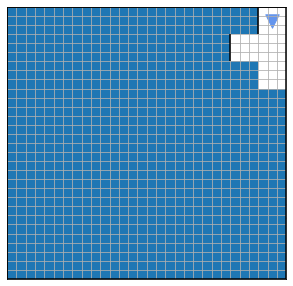

Input your direction (wasd) or 'p' for pause: s


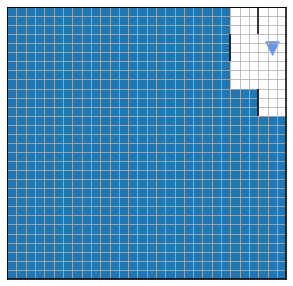

Input your direction (wasd) or 'p' for pause: s


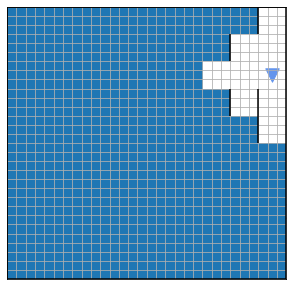

Input your direction (wasd) or 'p' for pause: s


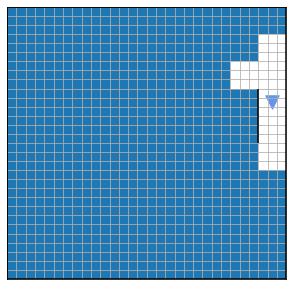

Input your direction (wasd) or 'p' for pause: s


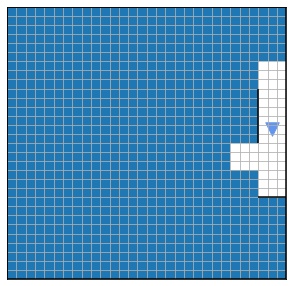

Input your direction (wasd) or 'p' for pause: s


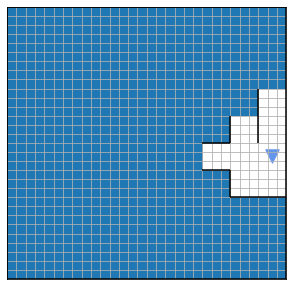

Input your direction (wasd) or 'p' for pause: a


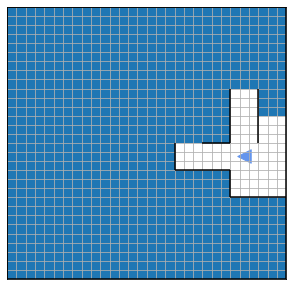

Input your direction (wasd) or 'p' for pause: a


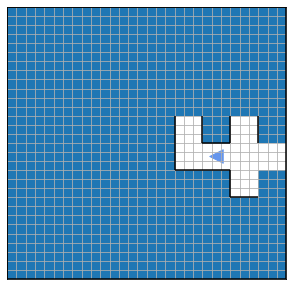

Input your direction (wasd) or 'p' for pause: a


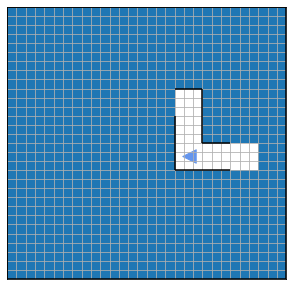

Input your direction (wasd) or 'p' for pause: w


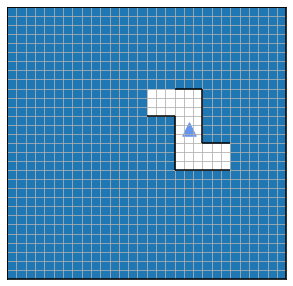

Input your direction (wasd) or 'p' for pause: w


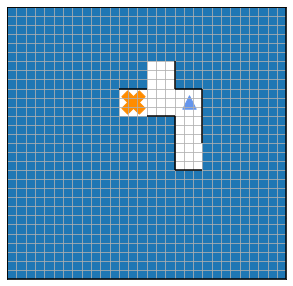

Hard :
{'eidolon': 1, 'the-lonely': 2}
Did you win? (y/n)a
Did you win? (y/n)y
Good work!


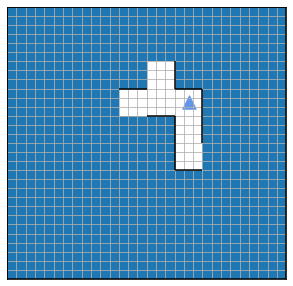

Input your direction (wasd) or 'p' for pause: a


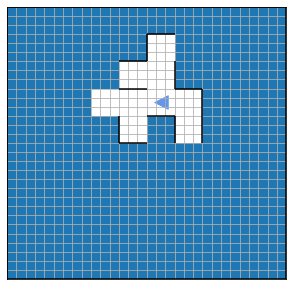

Input your direction (wasd) or 'p' for pause: a


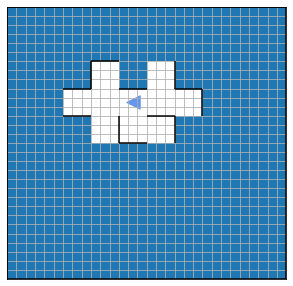

Input your direction (wasd) or 'p' for pause: a


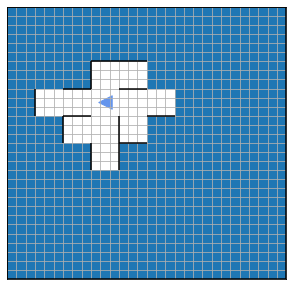

Input your direction (wasd) or 'p' for pause: s


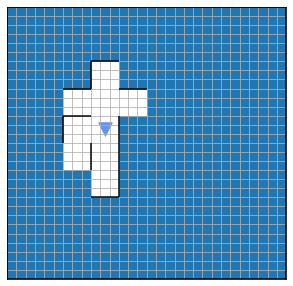

Input your direction (wasd) or 'p' for pause: s


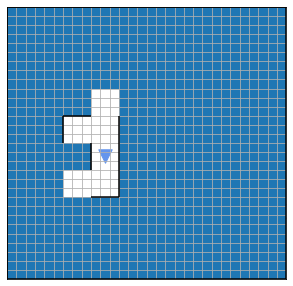

Input your direction (wasd) or 'p' for pause: s


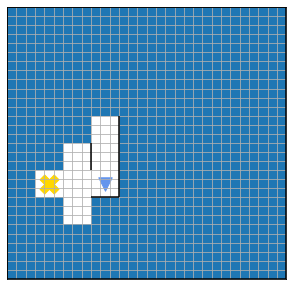

Medium :
{'azer': 1, 'grell': 3, 'clay-golem': 2}
Did you win? (y/n)a
Did you win? (y/n)y
Good work!


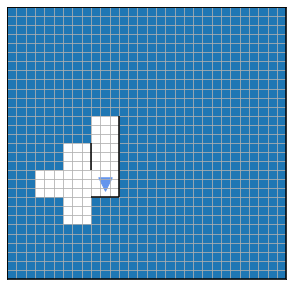

Input your direction (wasd) or 'p' for pause: a


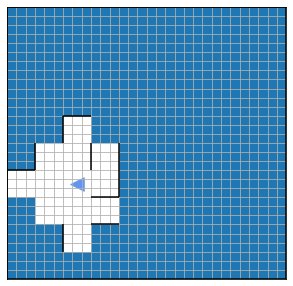

Input your direction (wasd) or 'p' for pause: s


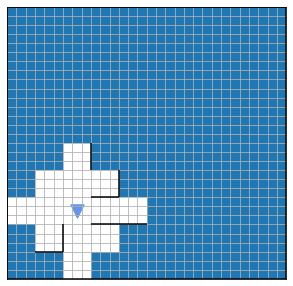

Input your direction (wasd) or 'p' for pause: s


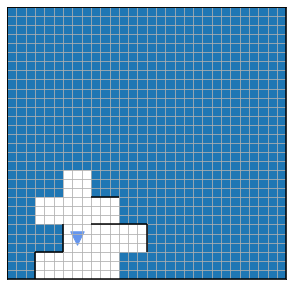

Input your direction (wasd) or 'p' for pause: w


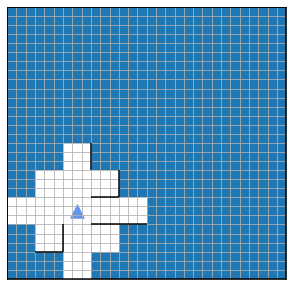

Input your direction (wasd) or 'p' for pause: a


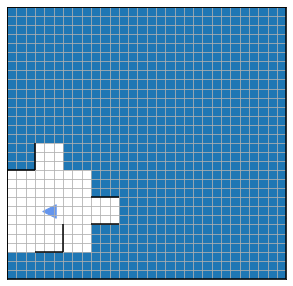

Input your direction (wasd) or 'p' for pause: a


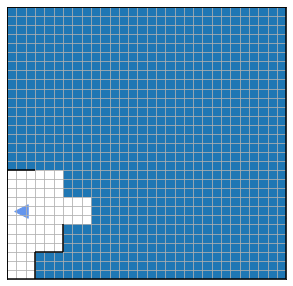

Input your direction (wasd) or 'p' for pause: d


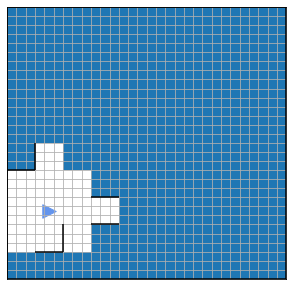

Input your direction (wasd) or 'p' for pause: d


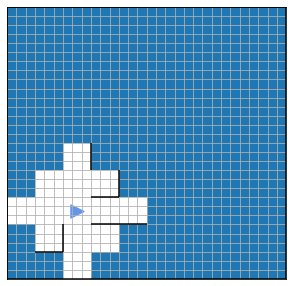

Input your direction (wasd) or 'p' for pause: s


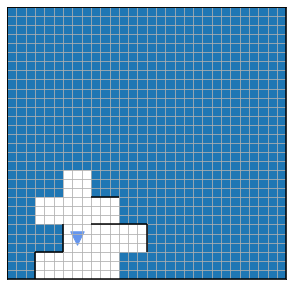

Input your direction (wasd) or 'p' for pause: d


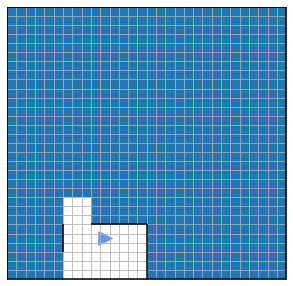

Input your direction (wasd) or 'p' for pause: s


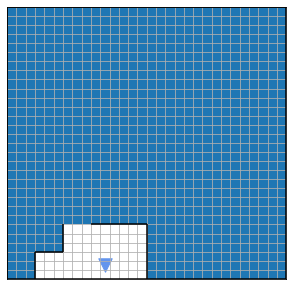

Input your direction (wasd) or 'p' for pause: a


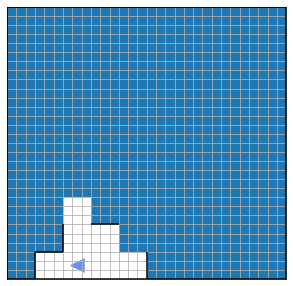

Input your direction (wasd) or 'p' for pause: w


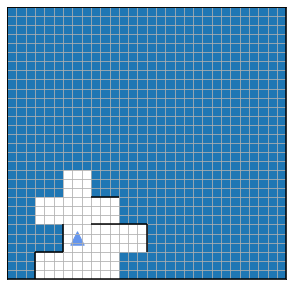

Input your direction (wasd) or 'p' for pause: w


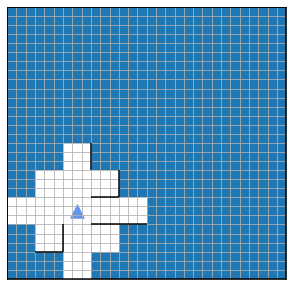

Input your direction (wasd) or 'p' for pause: w


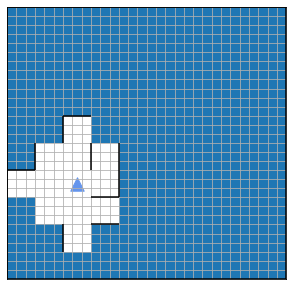

Input your direction (wasd) or 'p' for pause: w


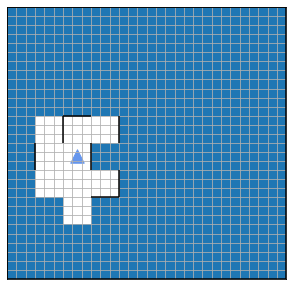

Input your direction (wasd) or 'p' for pause: w


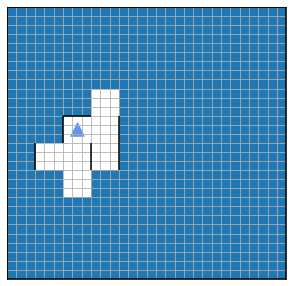

Input your direction (wasd) or 'p' for pause: s


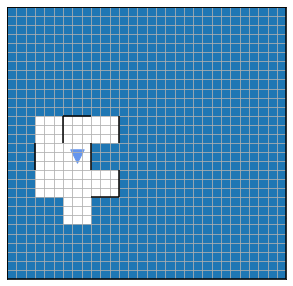

Input your direction (wasd) or 'p' for pause: a


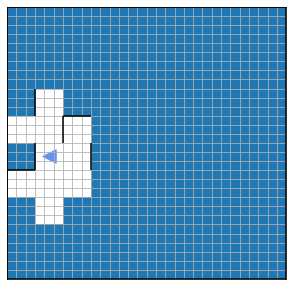

Input your direction (wasd) or 'p' for pause: w


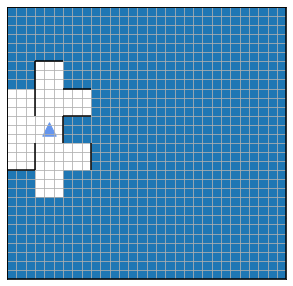

Input your direction (wasd) or 'p' for pause: w


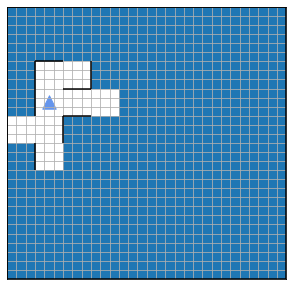

Input your direction (wasd) or 'p' for pause: s


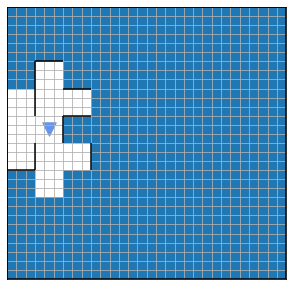

Input your direction (wasd) or 'p' for pause: a


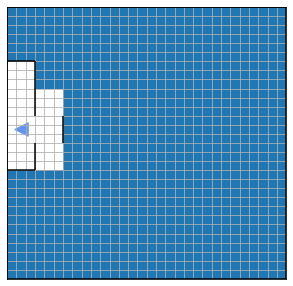

Input your direction (wasd) or 'p' for pause: w


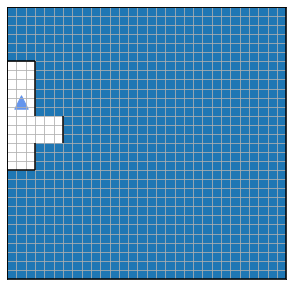

Input your direction (wasd) or 'p' for pause: s


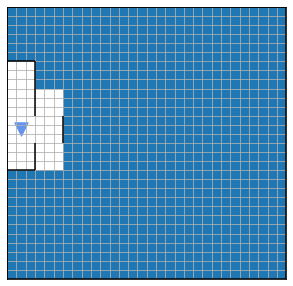

Input your direction (wasd) or 'p' for pause: d


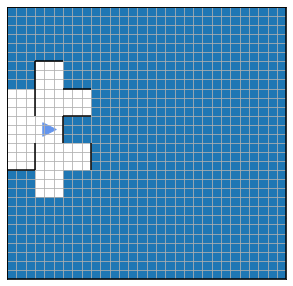

Input your direction (wasd) or 'p' for pause: w


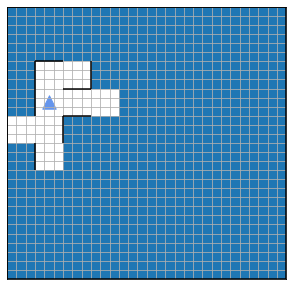

Input your direction (wasd) or 'p' for pause: w


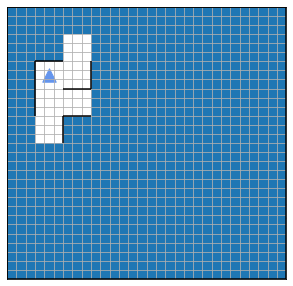

Input your direction (wasd) or 'p' for pause: d


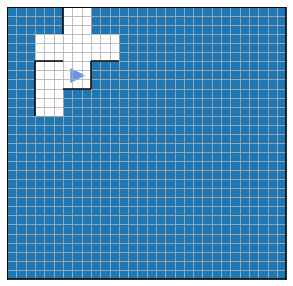

Input your direction (wasd) or 'p' for pause: w


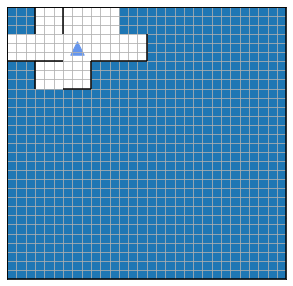

Input your direction (wasd) or 'p' for pause: a


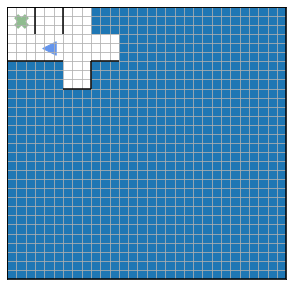

Easy :
{'brontosaurus': 3}
Input your direction (wasd) or 'p' for pause: a


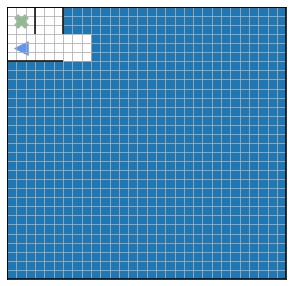

Easy :
{'brontosaurus': 3}
Did you win? (y/n)y
Good work!


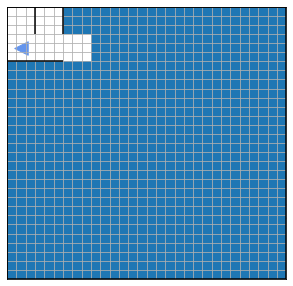

Input your direction (wasd) or 'p' for pause: d


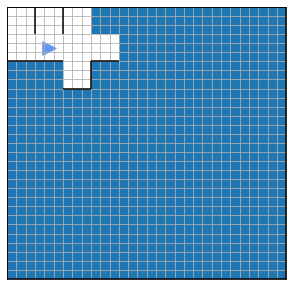

Input your direction (wasd) or 'p' for pause: d


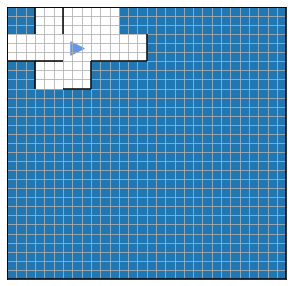

Input your direction (wasd) or 'p' for pause: d


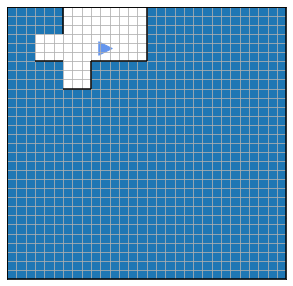

Input your direction (wasd) or 'p' for pause: w


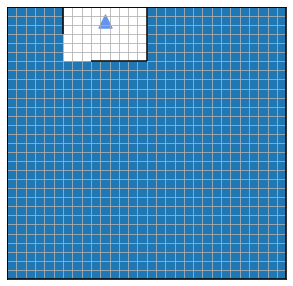

Input your direction (wasd) or 'p' for pause: a


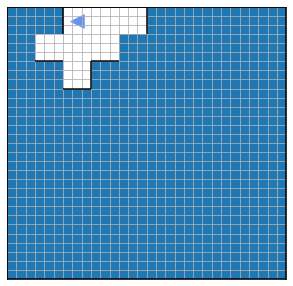

Input your direction (wasd) or 'p' for pause: s


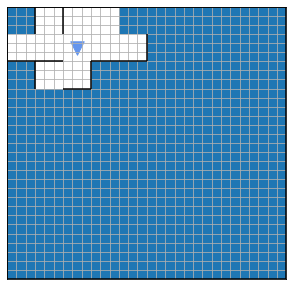

Input your direction (wasd) or 'p' for pause: d


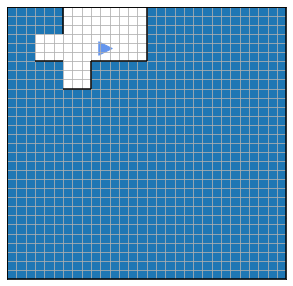

Input your direction (wasd) or 'p' for pause: a


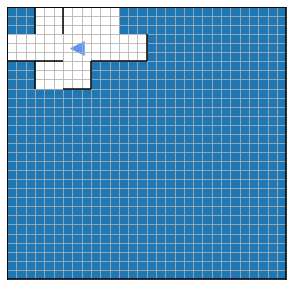

Input your direction (wasd) or 'p' for pause: s


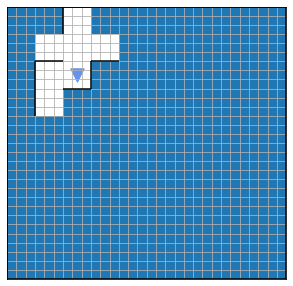

Input your direction (wasd) or 'p' for pause: a


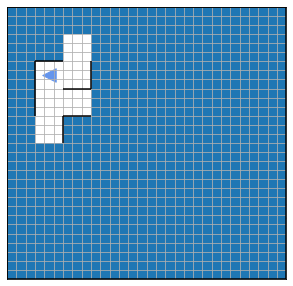

Input your direction (wasd) or 'p' for pause: s


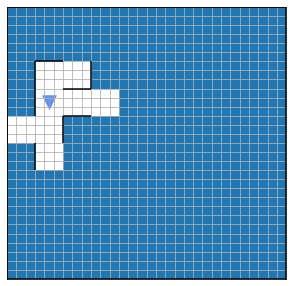

Input your direction (wasd) or 'p' for pause: d


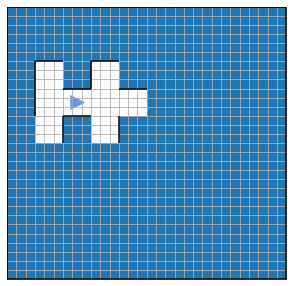

Input your direction (wasd) or 'p' for pause: d


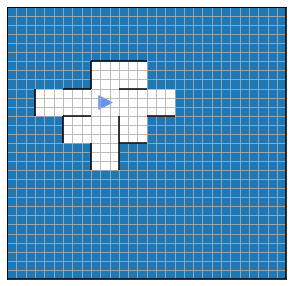

Input your direction (wasd) or 'p' for pause: d


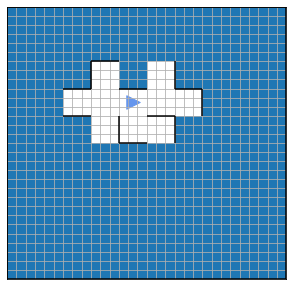

Input your direction (wasd) or 'p' for pause: s


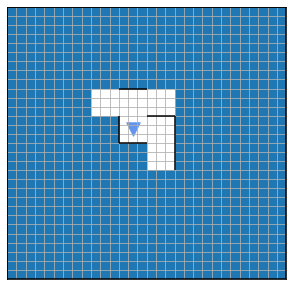

Input your direction (wasd) or 'p' for pause: d


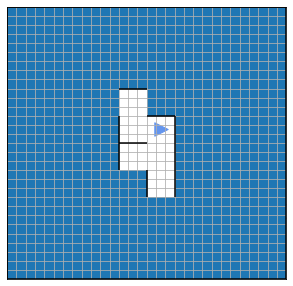

Input your direction (wasd) or 'p' for pause: s


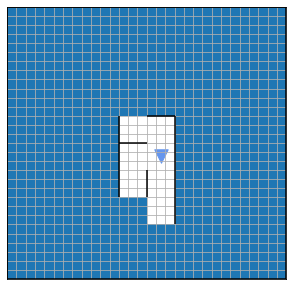

Input your direction (wasd) or 'p' for pause: s


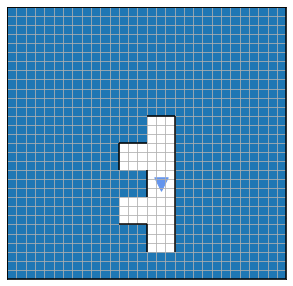

Input your direction (wasd) or 'p' for pause: s


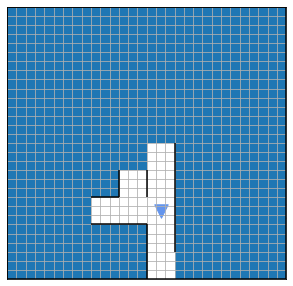

Input your direction (wasd) or 'p' for pause: s


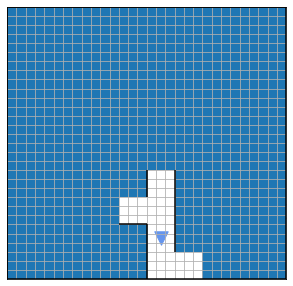

Input your direction (wasd) or 'p' for pause: w


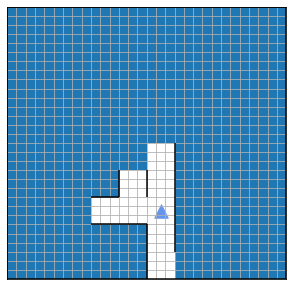

Input your direction (wasd) or 'p' for pause: a


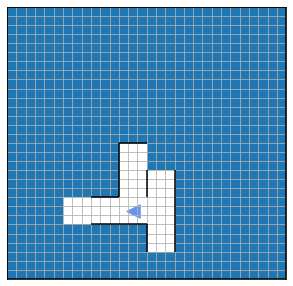

Input your direction (wasd) or 'p' for pause: w


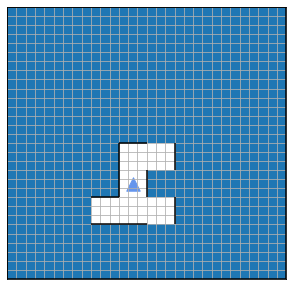

Input your direction (wasd) or 'p' for pause: s


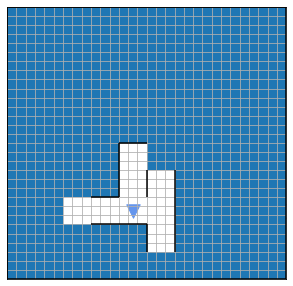

Input your direction (wasd) or 'p' for pause: a


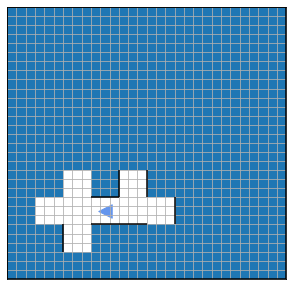

Input your direction (wasd) or 'p' for pause: a


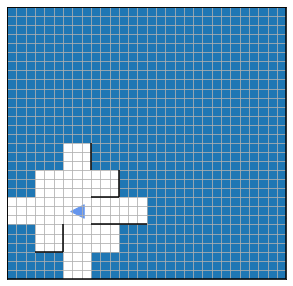

Input your direction (wasd) or 'p' for pause: s


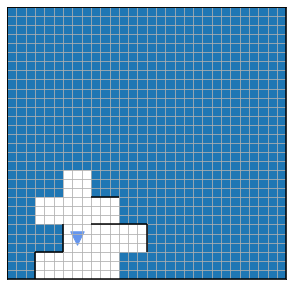

Input your direction (wasd) or 'p' for pause: d


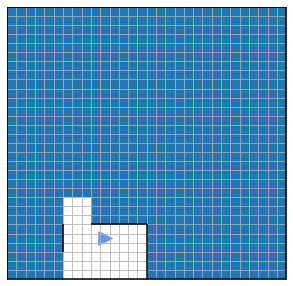

Input your direction (wasd) or 'p' for pause: a


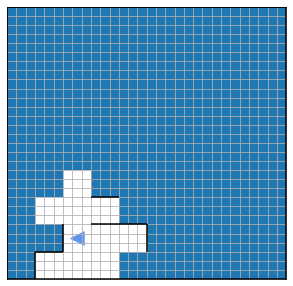

Input your direction (wasd) or 'p' for pause: w


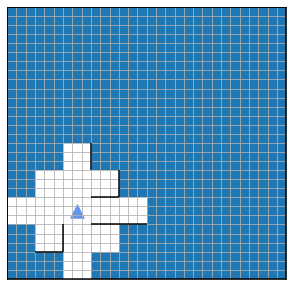

Input your direction (wasd) or 'p' for pause: a


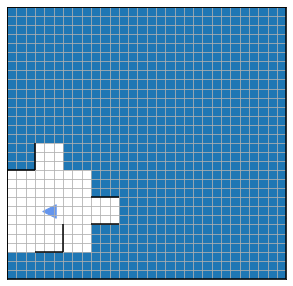

Input your direction (wasd) or 'p' for pause: s


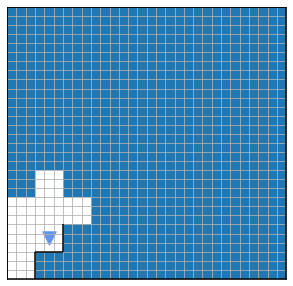

Input your direction (wasd) or 'p' for pause: w


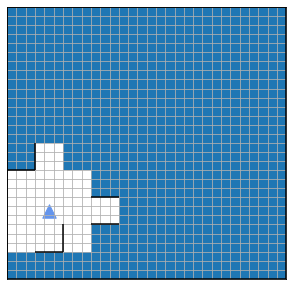

Input your direction (wasd) or 'p' for pause: d


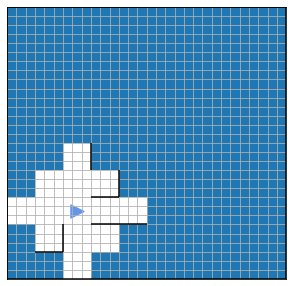

Input your direction (wasd) or 'p' for pause: d


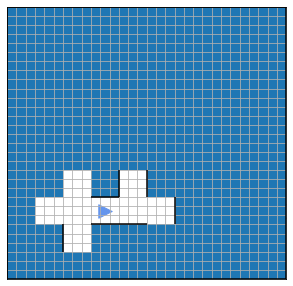

Input your direction (wasd) or 'p' for pause: d


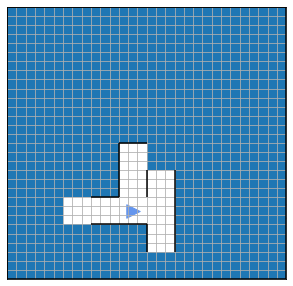

Input your direction (wasd) or 'p' for pause: d


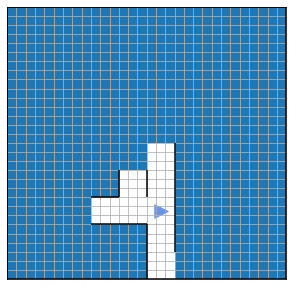

Input your direction (wasd) or 'p' for pause: s


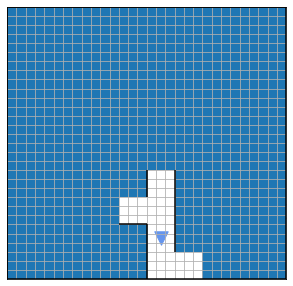

Input your direction (wasd) or 'p' for pause: s


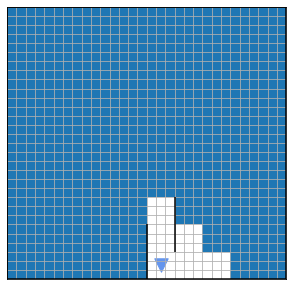

Input your direction (wasd) or 'p' for pause: d


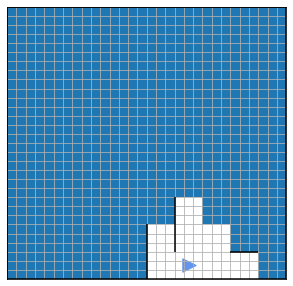

Input your direction (wasd) or 'p' for pause: w


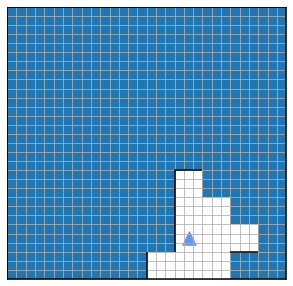

Input your direction (wasd) or 'p' for pause: s


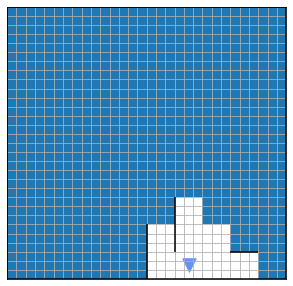

Input your direction (wasd) or 'p' for pause: d


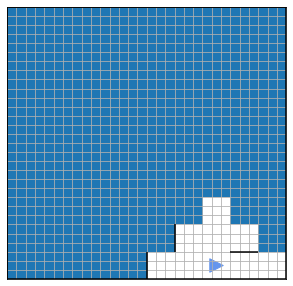

Input your direction (wasd) or 'p' for pause: w


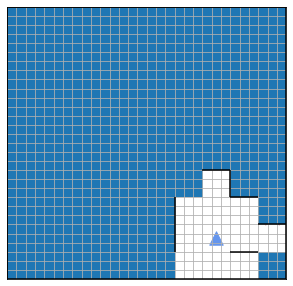

Input your direction (wasd) or 'p' for pause: w


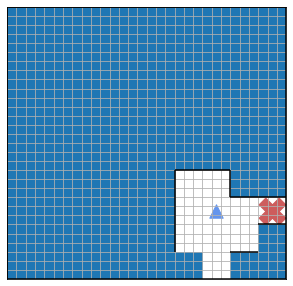

Deadly :
{'adult-green-dragon': 2, 'peryton': 1}
Did you win? (y/n)y
Good work!


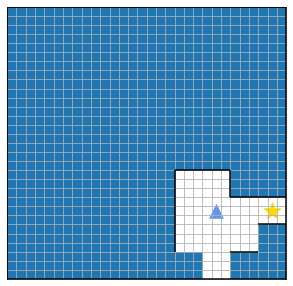

Input your direction (wasd) or 'p' for pause: d


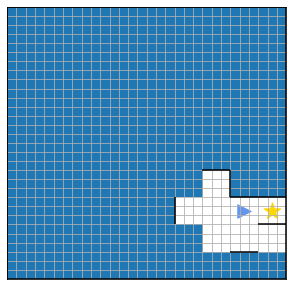

Input your direction (wasd) or 'p' for pause: d


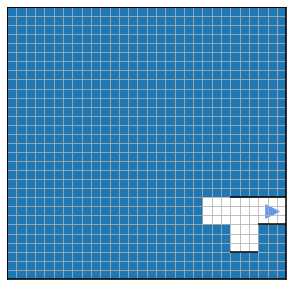

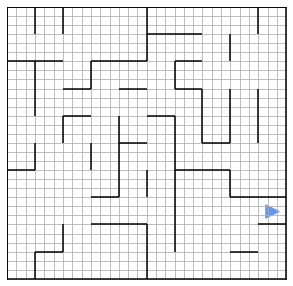

Treasure: 
{'coins': {'GP': 32000, 'PP': 24000},
 'gems': ['Jacinth (transparent fiery orange)',
          'Jacinth (transparent fiery orange)',
          'Jacinth (transparent fiery orange)'],
 'magic items': ['Universal solvent']}
You Win! :)
THE END.


In [234]:
dungeon.play()